# 0.データ読み込み

予測収量を利用した、収量と土壌パラメータの相関分析

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression



In [8]:
gpd_data = gpd.read_file('/workspaces/akita_daizu/data/474+120圃場.geojson')

In [10]:
soil_data = pd.read_excel('/workspaces/akita_daizu/data/0208修正_土壌データ+収量.xlsx', header=0)

UniquIDがふってある120圃場の解析だけで良いので、読み込んだ2ファイルを120圃場ののIDをKeyに接続する

In [11]:
# gpdの結合用うの行の削除と作成
gpd_data['作付け開始年'] = ''
gpd_data['圃場番号'] = gpd_data['uniqueID']
gpd_data['排水性の良否'] = gpd_data['pred_labels']
gpd_data['EVI20902mean'] = gpd_data['EVI2mean']

# gpdの必要な行だけ抽出して結合する ほしい行は以下の4行
selected_gpd = gpd_data[['圃場番号','排水性の良否','作付年_y', 'H23以前_y','播種月日','作付け開始年','EVI20902mean','EVI20903mean','geometry']]


In [12]:
#　この作付け年とH23以前を一つの列に。　まず作付け年が空ならH23以前を入れ込むようにFor
for index, row in selected_gpd[['作付年_y', 'H23以前_y','作付け開始年']].iterrows():
    if row['H23以前_y'] is not None :
        selected_gpd['作付け開始年'][index] =row['H23以前_y']
    elif  row['作付年_y'] is not None :
        selected_gpd['作付け開始年'][index] = row['作付年_y']

# それぞれの和暦を西暦に変更
# H23 2011 H24 2012 H25 2013 R1 2019
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ3～',r'2021',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ2～',r'2020',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ1～',r'2019',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ30～',r'2017',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ28～',r'2016',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ27～',r'2015',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ26～',r'2014',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ25～',r'2013',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ24～',r'2012',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'☑',r'2011',)
selected_gpd['作付け開始年'].unique()

target_selected_gpd = selected_gpd

/tmp/ipykernel_86613/436268765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] =row['H23以前_y']
/tmp/ipykernel_86613/436268765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] = row['作付年_y']
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(Ge

In [13]:
#まず　GPDとSOILデータでuniqueIDをキーにして全部結合する
merged_pd = pd.merge(soil_data, target_selected_gpd, on=['圃場番号'], how='inner')

In [14]:
# heatmap作成のため不要な行の削除 土壌硬度周り　土壌硬度は全部残す
# drop_columns = merged_pd.filter(like='土壌硬度', axis=1).columns.values
# droped_soil_data = merged_pd.drop(drop_columns, axis = 1)
# droped_soil_data.columns

In [16]:
# heatmap作成のため不要な行の削除
drop_columns = ['播種月日_x','生育状況','最大圧の深さの平均', '最大圧力の平均','調査日', '作付年_y', 'H23以前_y','現物重量ｋｇ', '計量時水分％', '圃場面積', '住所', '反収現物重量kg/10a',
       '15%時の重量','EVI20902mean', 'EVI20903mean']
second_droped_soil_data = merged_pd.drop(drop_columns, axis = 1)

In [17]:
#　解析に使う残した列
second_droped_soil_data.columns

Index(['圃場番号', '現場測定_EC(㎳／㎝)', '現場測定_PH', '土壌硬度_1_mean', '土壌硬度_2_mean',
       '土壌硬度_3_mean', '土壌硬度_4_mean', '土壌硬度_5_mean', '土壌硬度_6_mean',
       '土壌硬度_7_mean', '土壌硬度_8_mean', '土壌硬度_9_mean', '土壌硬度_10_mean',
       '土壌硬度_11_mean', '土壌硬度_12_mean', '土壌硬度_13_mean', '土壌硬度_14_mean',
       '土壌硬度_15_mean', '土壌硬度_16_mean', '土壌硬度_17_mean', '土壌硬度_18_mean',
       '土壌硬度_19_mean', '土壌硬度_20_mean', '土壌硬度_21_mean', '土壌硬度_22_mean',
       '土壌硬度_23_mean', '土壌硬度_24_mean', '土壌硬度_25_mean', '土壌硬度_26_mean',
       '土壌硬度_27_mean', '土壌硬度_28_mean', '土壌硬度_29_mean', '土壌硬度_30_mean',
       '土壌硬度_31_mean', '土壌硬度_32_mean', '土壌硬度_33_mean', '土壌硬度_34_mean',
       '土壌硬度_35_mean', '土壌硬度_36_mean', '土壌硬度_37_mean', '土壌硬度_38_mean',
       '土壌硬度_39_mean', '土壌硬度_40_mean', '土壌硬度_41_mean', '土壌硬度_42_mean',
       '土壌硬度_43_mean', '土壌硬度_44_mean', '土壌硬度_45_mean', '土壌硬度_46_mean',
       '土壌硬度_47_mean', '土壌硬度_48_mean', '土壌硬度_49_mean', '土壌硬度_50_mean',
       '土壌硬度_51_mean', '土壌硬度_52_mean', '土壌硬度_53_mean', '土壌硬度_54_mean',
       '土壌硬度

予測収量データの結合

In [18]:
pred_yield_data = pd.read_csv('/workspaces/akita_daizu/data/113_pred_yield.csv')

In [19]:
pred_yield_data.columns

Index(['Unnamed: 0', '圃場番号', '2021-06-25.tiffevi2_median',
       '2021-06-27.tiffevi2_median', '2021-06-28.tiffevi2_median',
       '2021-06-29.tiffevi2_median', '2021-06-30.tiffevi2_median',
       '2021-07-01.tiffevi2_median', '2021-07-02.tiffevi2_median',
       '2021-07-07.tiffevi2_median', '2021-07-14.tiffevi2_median',
       '2021-07-15.tiffevi2_median', '2021-07-16.tiffevi2_median',
       '2021-07-17.tiffevi2_median', '2021-07-18.tiffevi2_median',
       '2021-07-20.tiffevi2_median', '2021-07-21.tiffevi2_median',
       '2021-07-24.tiffevi2_median', '2021-07-25.tiffevi2_median',
       '2021-07-26.tiffevi2_median', '2021-07-30.tiffevi2_median',
       '2021-07-31.tiffevi2_median', '2021-08-02.tiffevi2_median',
       '2021-08-03.tiffevi2_median', '2021-08-05.tiffevi2_median',
       '2021-08-06.tiffevi2_median', '2021-08-07.tiffevi2_median',
       '2021-08-15.tiffevi2_median', '2021-08-20.tiffevi2_median',
       '2021-09-02.tiffevi2_median', '2021-09-03.tiffevi2_median',
   

In [20]:
pred_yield_data['圃場番号'] = pred_yield_data['圃場番号'].astype(str)
pred_yield_data['圃場番号'] = pred_yield_data['圃場番号'].str.replace('\.0',"")

/tmp/ipykernel_86613/3335956090.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_yield_data['圃場番号'] = pred_yield_data['圃場番号'].str.replace('\.0',"")


In [21]:
second_droped_soil_data['圃場番号'] = second_droped_soil_data['圃場番号'].astype(str)
second_droped_soil_data['圃場番号'] = second_droped_soil_data['圃場番号'].str.replace('\.0',"")

/tmp/ipykernel_86613/2683178143.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  second_droped_soil_data['圃場番号'] = second_droped_soil_data['圃場番号'].str.replace('\.0',"")


In [22]:
predyield_soil_data = pd.merge(second_droped_soil_data, pred_yield_data, on=['圃場番号'], how='inner')

In [23]:
predyield_soil_data.drop_duplicates

<bound method DataFrame.drop_duplicates of     圃場番号  現場測定_EC(㎳／㎝)  現場測定_PH  土壌硬度_1_mean  土壌硬度_2_mean  土壌硬度_3_mean  \
0      1         0.028     7.36          285          486          650   
1      2         0.031     6.42          232          232          232   
2      3         0.027     6.30          232          232          232   
3      4         0.017     6.49          232          289          325   
4      5         0.058     6.69          232          295          398   
..   ...           ...      ...          ...          ...          ...   
109  117         0.034     5.83          362          375          375   
110  118         0.028     5.46          232          237          239   
111  119         0.044     5.70          365          376          376   
112  120         0.055     6.06          670          652          630   
113  121         0.045     5.76          310          345          354   

     土壌硬度_4_mean  土壌硬度_5_mean  土壌硬度_6_mean  土壌硬度_7_mean  ...  \
0   

In [24]:
# 作付け開始年はこれでint化　播種日はエクセルで日付けにしとく
predyield_soil_data['作付け開始年'] = predyield_soil_data['作付け開始年'].map(lambda x: int(x))
predyield_soil_data['播種月日_y'].unique()


array(['2021-07-04', '2021-06-30', '2021-07-07', '2021-07-01',
       '2021-07-09', '2021-06-29', '2021-06-26', '2021-06-27'],
      dtype=object)

In [25]:
predyield_soil_data['播種月日_y'] = pd.to_datetime(predyield_soil_data['播種月日_y'])

In [26]:
# 播種日datatime形式だとheatmap作成時に読み込まれない？ intにする
int_time = predyield_soil_data['播種月日_y'].map(pd.Timestamp.timestamp).astype(int)
# これに変換するともとのDatetimeに戻せない

In [27]:
int_time = predyield_soil_data['播種月日_y'].dt.strftime('%m%d')
int2_time = int_time.str.lstrip('0').astype(int)

In [28]:
# これで播種月日はただの連続値になる
predyield_soil_data['播種月日'] = int2_time
predyield_soil_data = predyield_soil_data.drop(['播種月日_y'], axis = 1)

In [29]:
# これで収量が入っている行には必ず作付け開始年も入力される
print(second_droped_soil_data.isnull().sum())

圃場番号            0
現場測定_EC(㎳／㎝)    0
現場測定_PH         0
土壌硬度_1_mean     0
土壌硬度_2_mean     0
               ..
TN(%)           0
排水性の良否          0
播種月日_y          0
作付け開始年          0
geometry        0
Length: 78, dtype: int64


In [30]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(predyield_soil_data["SoilName"].values)

#データ変換
predyield_soil_data["土壌_CD"] = LE.fit_transform(predyield_soil_data["SoilName"].values)
print(predyield_soil_data["土壌_CD"].unique())
print(predyield_soil_data["SoilName"].unique())

[1 2 0]
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']


In [31]:
predyield_soil_data.to_csv('/workspaces/akita_daizu/data/113_predyield+fielddata.csv')

# 1.収量と各パラメータの相関分析

## 1-1 全体の相関について

In [32]:
predyield_soil_data.columns

Index(['圃場番号', '現場測定_EC(㎳／㎝)', '現場測定_PH', '土壌硬度_1_mean', '土壌硬度_2_mean',
       '土壌硬度_3_mean', '土壌硬度_4_mean', '土壌硬度_5_mean', '土壌硬度_6_mean',
       '土壌硬度_7_mean',
       ...
       '2021-10-25.tiffevi2_median', '2021-11-01.tiffevi2_median',
       '2021-11-02.tiffevi2_median', '2021-11-06.tiffevi2_median',
       '2021-11-07.tiffevi2_median', 'yield', 'geometry_y', 'predyield',
       '播種月日', '土壌_CD'],
      dtype='object', length=133)

In [33]:
predyield_soil_data_org = predyield_soil_data.copy()
predyield_soil_data_org['予測収量'] = predyield_soil_data_org['predyield']
predyield_soil_data_org = predyield_soil_data_org.drop_duplicates(subset=['圃場番号'])

In [34]:
# 土壌硬度などドロップ
soil_data_sort = predyield_soil_data_org[['予測収量','15%反収現物重量kg/10a','土壌硬度_40_mean','播種月日','現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','作付け開始年','SoilName','土壌_CD']]

In [35]:
corr = soil_data_sort.corr()
corr

,予測収量,15%反収現物重量kg/10a,土壌硬度_40_mean,播種月日,現場測定_EC(㎳／㎝),現場測定_PH,実験室測定_EC(㎳／㎝),実験室測定_pH,アンモニア態窒素(mgN/100g),硝酸態窒素(mgN/100g),可給隊窒素(mgN/100g),有効態リン酸(mgP2O5/100g),TC(%),腐食(%),TN(%),作付け開始年,土壌_CD
予測収量,1.000000,0.939058,-0.154831,-0.377272,0.072511,0.066533,0.212218,0.070632,0.045050,0.085611,0.056815,0.093311,-0.024501,-0.024250,-0.036111,-0.114014,-0.210525
15%反収現物重量kg/10a,0.939058,1.000000,-0.429049,-0.416017,0.030508,0.346467,0.083840,0.273339,0.093507,0.099933,-0.181972,0.034223,-0.359270,-0.359246,-0.361565,-0.342801,-0.341941
土壌硬度_40_mean,-0.154831,-0.429049,1.000000,-0.022003,0.023193,-0.325514,0.178187,-0.211194,-0.028602,0.047168,0.062464,0.064479,0.218493,0.218531,0.225328,0.021177,0.114320
播種月日,-0.377272,-0.416017,-0.022003,1.000000,-0.468690,0.460251,-0.580348,0.471733,-0.145888,-0.457861,-0.371374,-0.353504,-0.270814,-0.270875,-0.372598,0.021528,-0.043923
現場測定_EC(㎳／㎝),0.072511,0.030508,0.023193,-0.468690,1.000000,-0.204528,0.262465,-0.001793,-0.005198,0.346549,0.373814,0.363274,0.039033,0.038848,0.121615,-0.022069,-0.187576
現場測定_PH,0.066533,0.346467,-0.325514,0.460251,-0.204528,1.000000,-0.469029,0.862477,-0.021173,-0.278153,-0.491239,-0.132003,-0.580862,-0.580748,-0.616960,-0.203084,-0.269811
実験室測定_EC(㎳／㎝),0.212218,0.083840,0.178187,-0.580348,0.262465,-0.469029,1.000000,-0.596251,0.137055,0.505118,0.355975,0.277629,0.541995,0.542086,0.611209,-0.056051,0.159333
実験室測定_pH,0.070632,0.273339,-0.211194,0.471733,-0.001793,0.862477,-0.596251,1.000000,-0.088318,-0.319580,-0.409891,-0.081186,-0.669973,-0.669881,-0.701202,-0.133669,-0.388275
アンモニア態窒素(mgN/100g),0.045050,0.093507,-0.028602,-0.145888,-0.005198,-0.021173,0.137055,-0.088318,1.000000,0.252312,-0.181268,0.063492,0.066767,0.066825,0.116624,-0.060554,0.181257
硝酸態窒素(mgN/100g),0.085611,0.099933,0.047168,-0.457861,0.346549,-0.278153,0.505118,-0.319580,0.252312,1.000000,0.049043,0.368095,0.446396,0.446281,0.510219,-0.023507,0.164603


<AxesSubplot:>

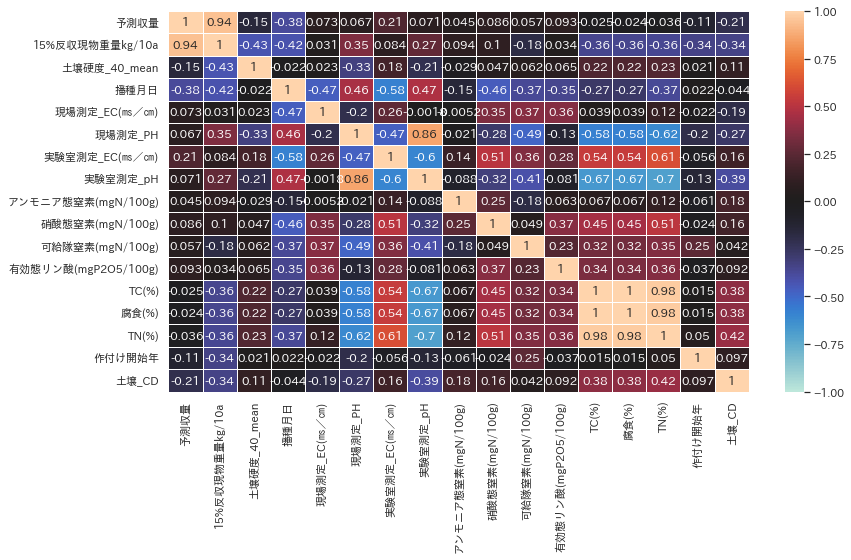

In [45]:
# sns　setするとフォントもデフォルトのsans serifになって文字化けするから、Plotサイズ変える時にフォントも指定する
sns.set(rc = {'figure.figsize':(13,7)},font='IPAexGothic')
sns.heatmap(corr,annot=True, vmax=1, vmin=-1, center=0,linewidths=.5)

In [162]:
target_yield = "予測収量"
target_column = "15%反収現物重量kg/10a" 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


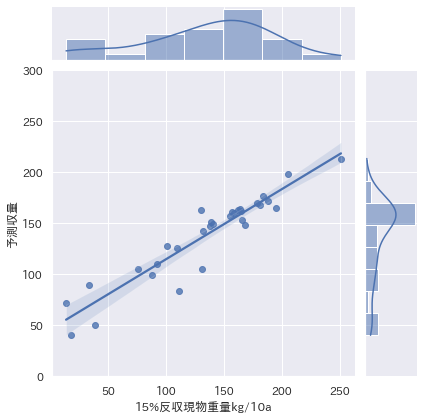

In [163]:
plot = sns.jointplot(soil_data_wo_error_sort[target_column],soil_data_wo_error_sort[target_yield],  kind="reg")
# plot.ax_marg_x.set_xlim(0, 3000)
plot.ax_marg_y.set_ylim(0, 300)
plt.show()

収量のデータが過学習起こしている可能性

## 1-2詳細分析

In [164]:
predyield_soil_data_org = predyield_soil_data.copy()
predyield_soil_data_org['予測収量'] = predyield_soil_data_org['predyield']
predyield_soil_data_org = predyield_soil_data_org.drop_duplicates(subset=['圃場番号'])
# 土壌硬度などドロップ
soil_data_sort = predyield_soil_data_org[['予測収量','15%反収現物重量kg/10a', '現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','作付け開始年','SoilName','土壌_CD']]

In [165]:
# 相関を確認するデータをグループ分けして　個別のパラメータとランダム効果の比較
# 1.土壌をランダム効果として各パラメータの相関を見る
data_random_soil_sort = soil_data_sort[['予測収量','15%反収現物重量kg/10a', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)', '土壌_CD']]


# 3.作付け開始年をランダム効果として各パラメータの相関を見る
data_random_year_sort = soil_data_sort[['予測収量','15%反収現物重量kg/10a', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)', '作付け開始年']]

土壌分類対応表
[1 2 0]  
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']

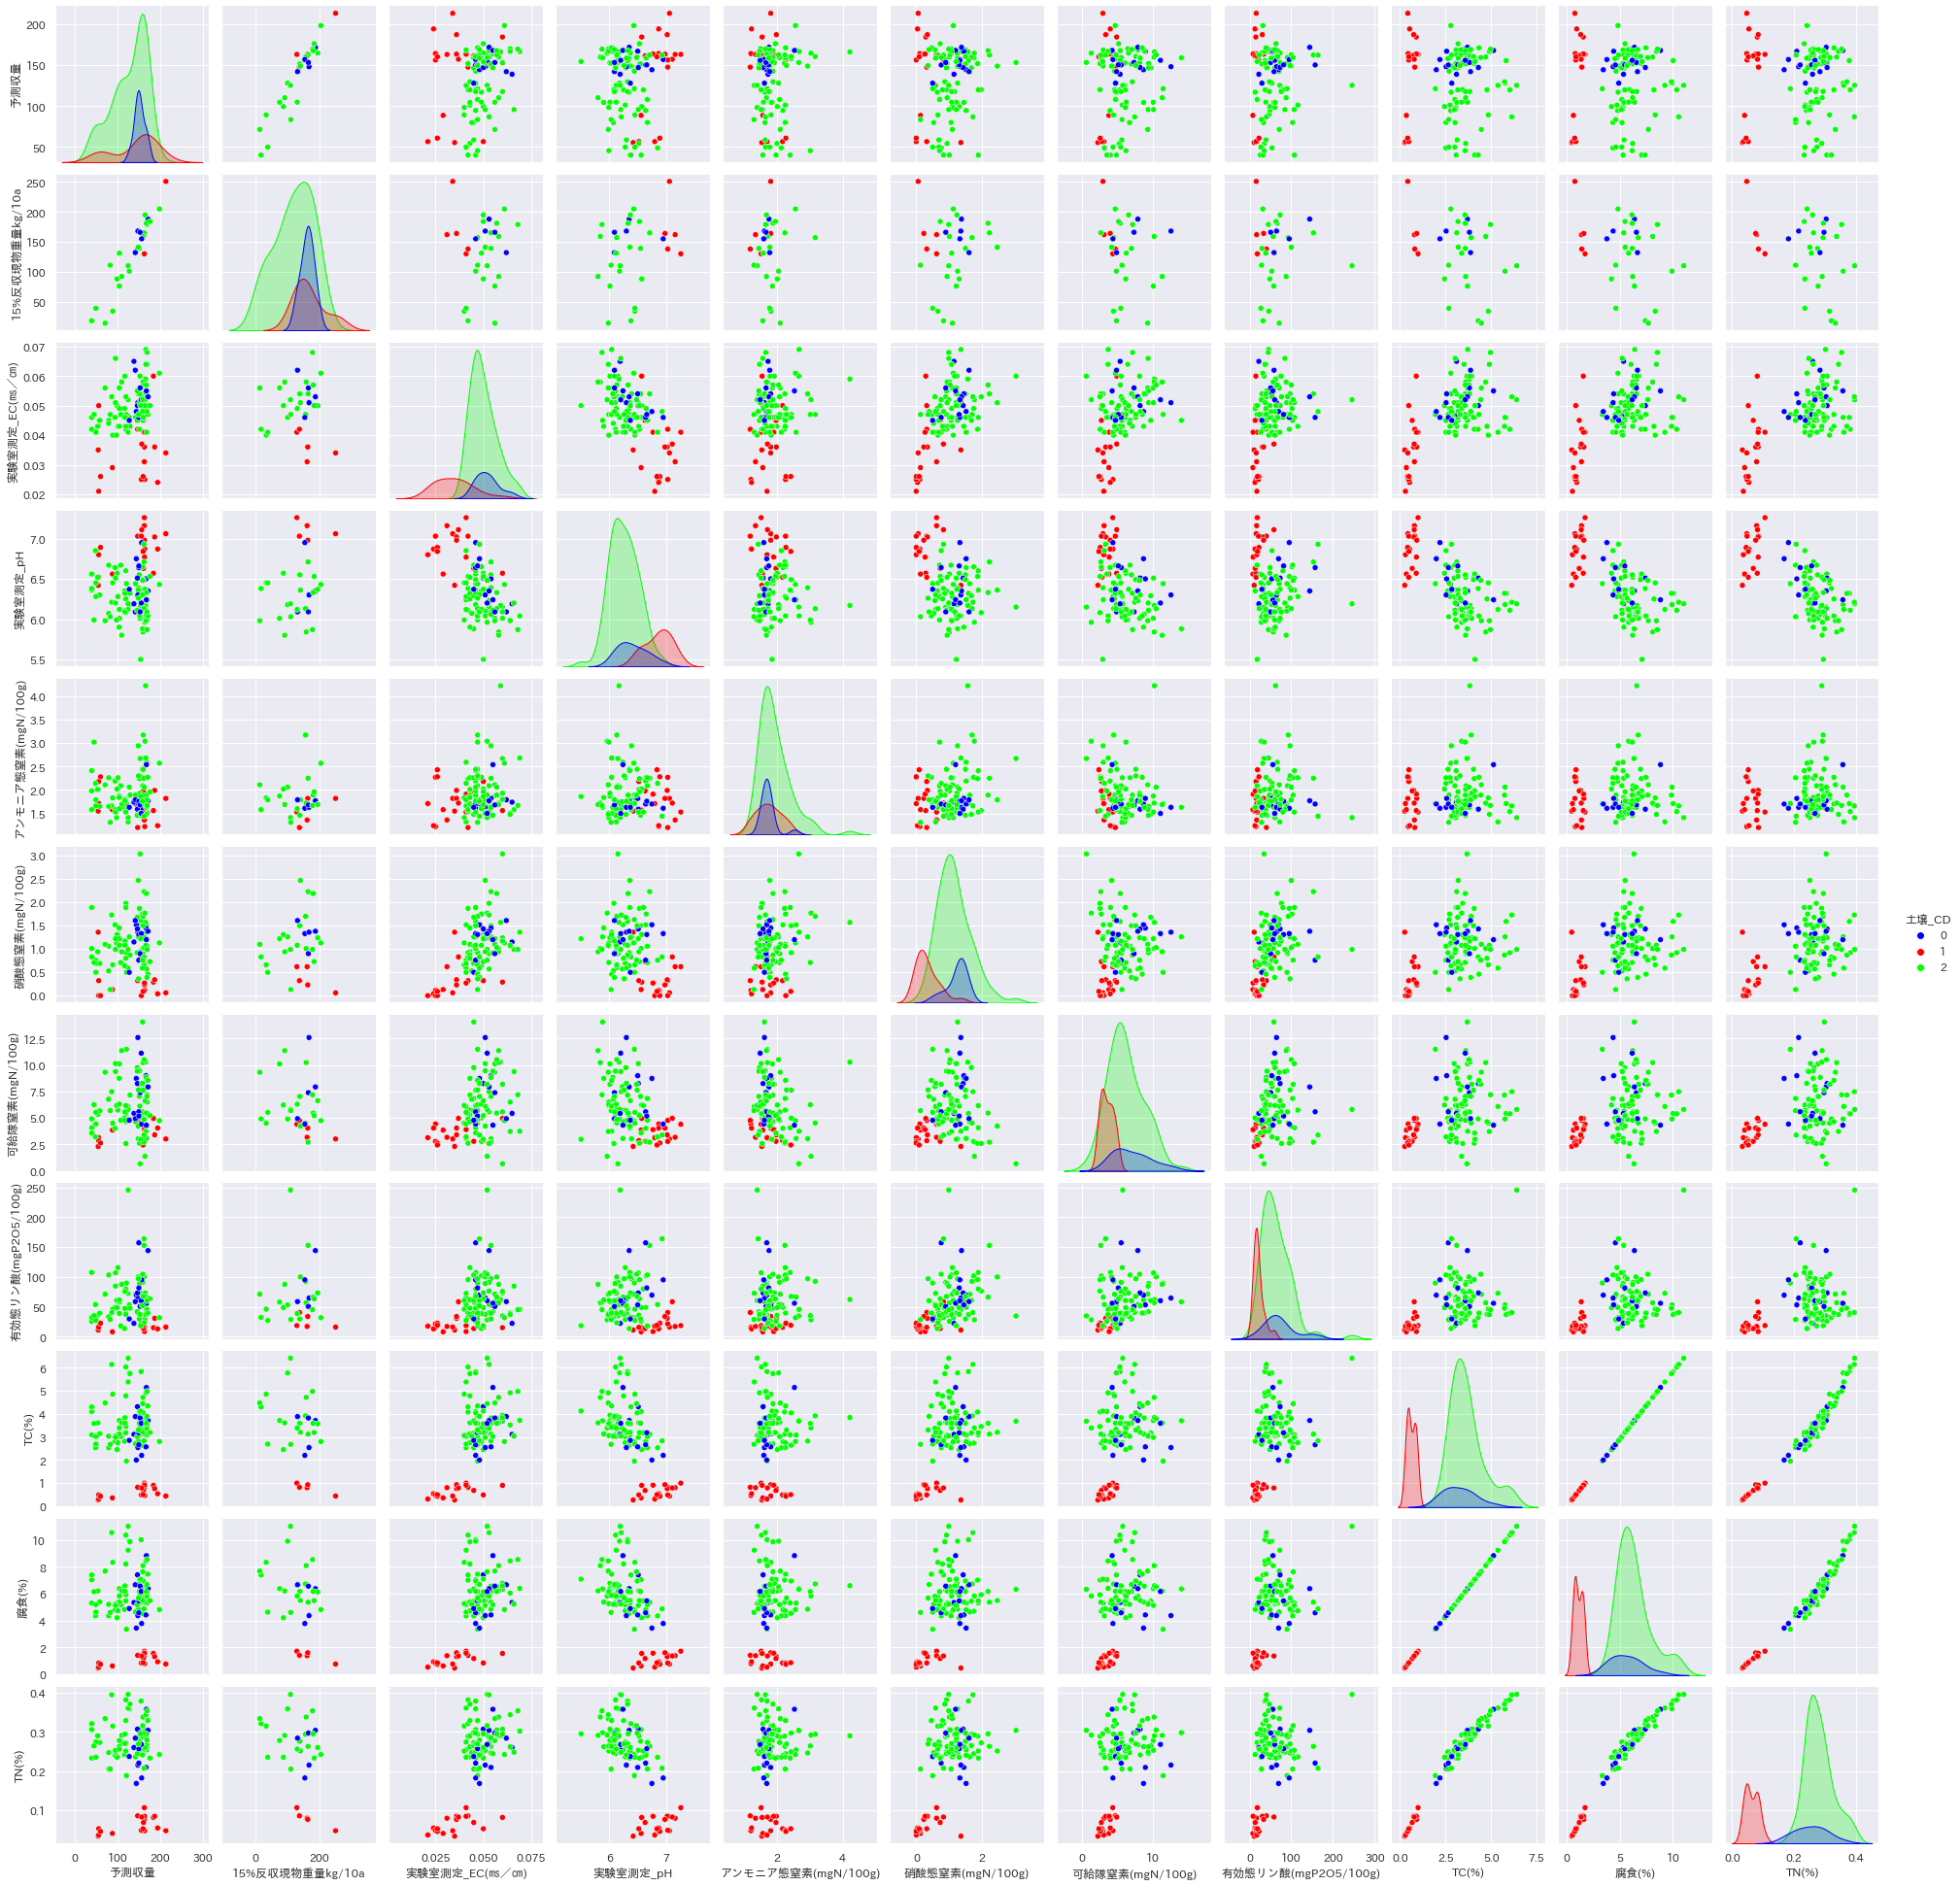

In [166]:
# 赤が'典型普通砂質未熟土'　緑が'淡色普通非アロフェン質黒ボク'　青が'グライ低地土'
sns.pairplot(data_random_soil_sort, hue="土壌_CD", palette={1: 'red',2: '#00ff00',0: 'blue'})

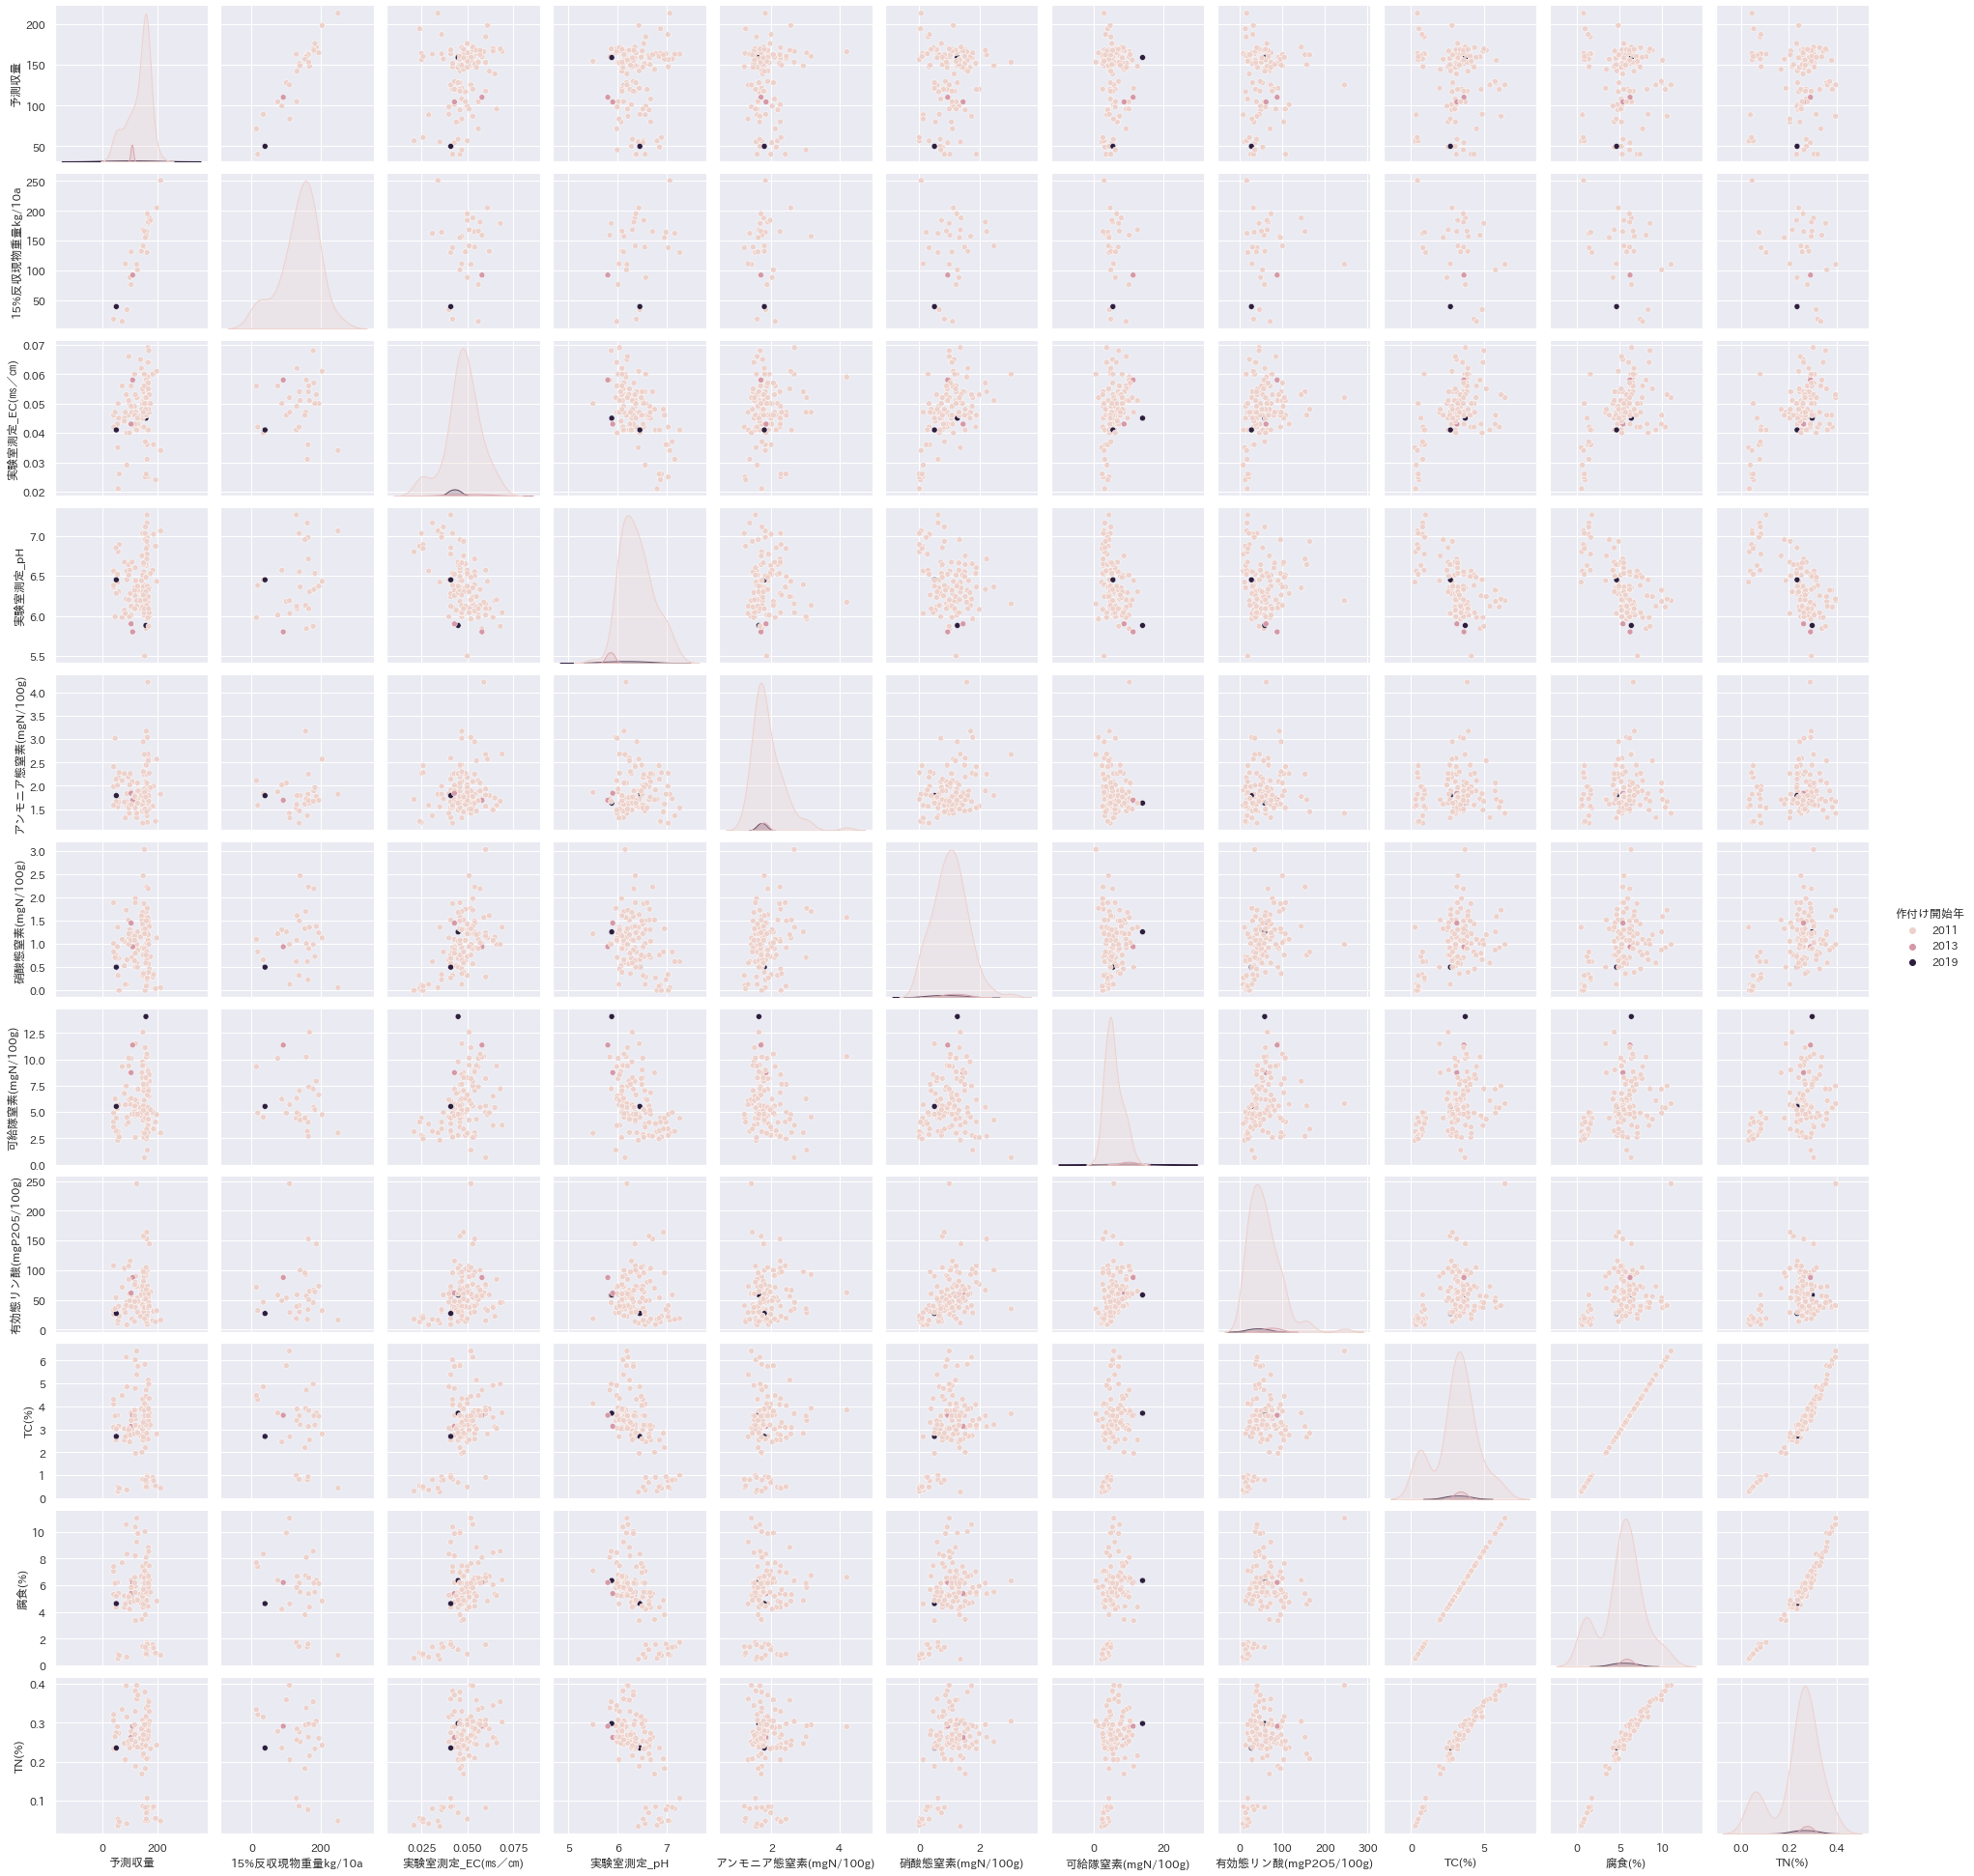

In [167]:
#　作付け開始年での評価
sns.pairplot(data_random_year_sort, hue="作付け開始年")

In [168]:
print(second_droped_soil_data.isnull().sum())

圃場番号            0
現場測定_EC(㎳／㎝)    0
現場測定_PH         0
土壌硬度_1_mean     0
土壌硬度_2_mean     0
               ..
TN(%)           0
排水性の良否          0
播種月日_y          0
作付け開始年          0
geometry        0
Length: 78, dtype: int64


### 1-2-1 収量と各パラメータの関係


腐食はTCの線形変換なので。これ以降の処理では計算から外す

In [124]:
predyield_soil_data

,圃場番号,現場測定_EC(㎳／㎝),現場測定_PH,土壌硬度_1_mean,土壌硬度_2_mean,土壌硬度_3_mean,土壌硬度_4_mean,土壌硬度_5_mean,土壌硬度_6_mean,土壌硬度_7_mean,...,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,yield,geometry_y,predyield,播種月日,土壌_CD
0,1,0.028,7.36,285,486,650,779,822,887,959,...,1.298541,1.237592,1.186793,1.039675,0.965338,130.0,"POLYGON ((140.0216142734536 40.26848425100889,...",163.169406,704,1
1,2,0.031,6.42,232,232,232,232,232,232,232,...,0.815784,0.812366,0.724132,0.699096,0.692027,NaN,"POLYGON ((140.0214374856136 40.27121568660164,...",55.456022,704,1
2,3,0.027,6.30,232,232,232,232,247,334,421,...,1.096748,1.061513,0.921408,0.852873,0.839075,NaN,"POLYGON ((140.0227600065069 40.27166649631877,...",88.648438,704,1
3,4,0.017,6.49,232,289,325,370,411,507,669,...,1.378049,1.279071,1.038160,0.886470,0.873807,NaN,"POLYGON ((140.0213209044884 40.27196261244941,...",164.194410,704,1
4,5,0.058,6.69,232,295,398,579,728,1149,1336,...,1.342261,1.252035,1.012295,0.867735,0.851494,138.0,"POLYGON ((140.021189675048 40.27220714559763, ...",147.590538,704,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117,0.034,5.83,362,375,375,372,411,494,689,...,1.136029,1.134162,1.133639,1.110234,1.102329,NaN,"POLYGON ((140.0860195621185 40.28704134522226,...",171.237964,627,2
110,118,0.028,5.46,232,237,239,239,239,239,382,...,1.161338,1.178836,1.197126,1.184975,1.182244,NaN,"POLYGON ((140.0859326339478 40.28709332440978,...",154.465816,627,2
111,119,0.044,5.70,365,376,376,440,463,516,573,...,1.281533,1.251259,1.236671,1.165268,1.108512,NaN,"POLYGON ((140.0857509810808 40.28721807406166,...",169.097911,627,2
112,120,0.055,6.06,670,652,630,682,598,733,749,...,1.447051,1.377366,1.334956,1.174714,1.041394,NaN,"POLYGON ((140.0855299036319 40.28736390566991,...",158.570285,627,2


In [125]:
predyield_soil_data_org = predyield_soil_data.copy()
predyield_soil_data_org['予測収量'] = predyield_soil_data_org['predyield']
predyield_soil_data_org = predyield_soil_data_org.drop_duplicates(subset=['圃場番号'])
# 土壌硬度などドロップ
soil_data_sort = predyield_soil_data_org[['予測収量','15%反収現物重量kg/10a', '現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','播種月日','作付け開始年','SoilName','土壌_CD']]

In [126]:
data_only_yield_soil_sort = soil_data_sort[['予測収量','実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', '土壌_CD','15%反収現物重量kg/10a']]

data_only_yield_year_sort = soil_data_sort[['予測収量','実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', "作付け開始年",'15%反収現物重量kg/10a']]

data_only_yield_date_sort = soil_data_sort[['予測収量','実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', '播種月日','15%反収現物重量kg/10a']]

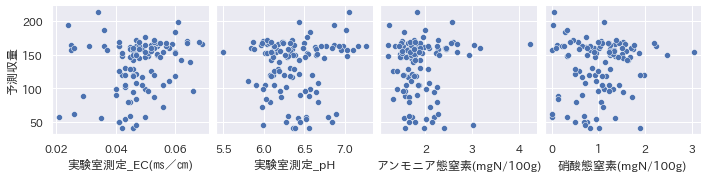

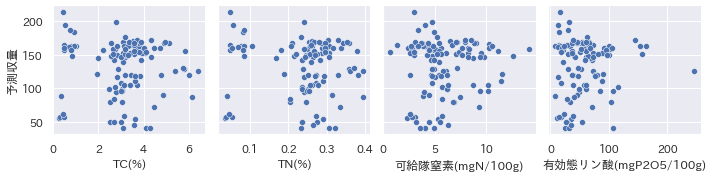

In [116]:
# ただの散布図だけの表示
sns.pairplot(data_only_yield_soil_sort,  x_vars=['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)'],
             y_vars=['予測収量'])
sns.pairplot(data_only_yield_soil_sort, x_vars=[ 'TC(%)',  'TN(%)','可給隊窒素(mgN/100g)','有効態リン酸(mgP2O5/100g)'] ,
             y_vars=['予測収量'])

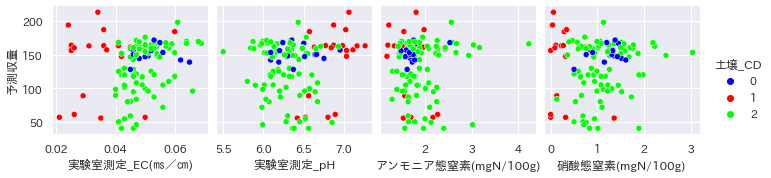

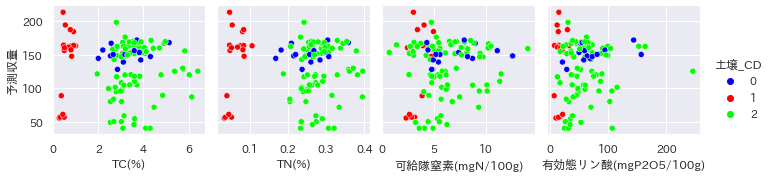

In [117]:
# 赤が'典型普通砂質未熟土'　緑が'淡色普通非アロフェン質黒ボク'　青が'グライ低地土'
sns.pairplot(data_only_yield_soil_sort, hue="土壌_CD", x_vars=['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)'],
             y_vars=['予測収量'], palette={1: 'red',2: '#00ff00',0: 'blue'})
sns.pairplot(data_only_yield_soil_sort, hue="土壌_CD",x_vars=[ 'TC(%)',  'TN(%)','可給隊窒素(mgN/100g)','有効態リン酸(mgP2O5/100g)'] ,
             y_vars=['予測収量'], palette={1: 'red',2: '#00ff00',0: 'blue'})

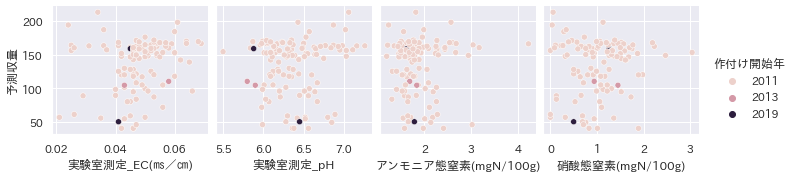

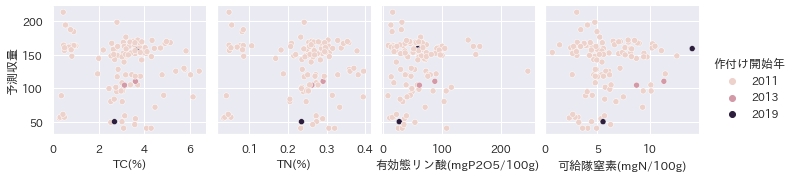

In [128]:
sns.pairplot(data_only_yield_year_sort, hue="作付け開始年", x_vars=['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)'],
             y_vars=['予測収量'])
sns.pairplot(data_only_yield_year_sort, hue="作付け開始年",x_vars=['TC(%)', 'TN(%)','有効態リン酸(mgP2O5/100g)', '可給隊窒素(mgN/100g)'],
             y_vars=['予測収量'])

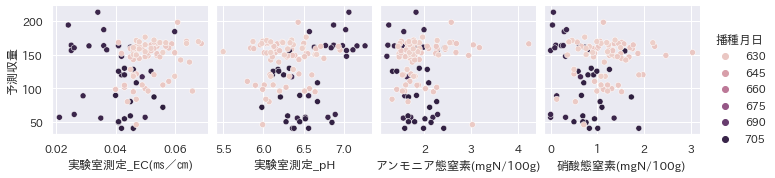

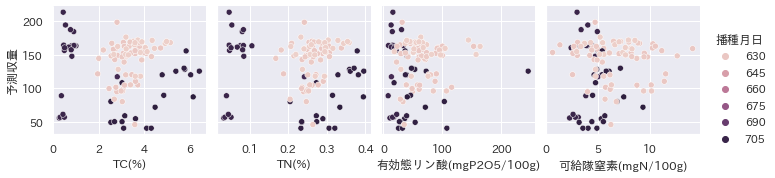

In [129]:
sns.pairplot(data_only_yield_date_sort, hue="播種月日", x_vars=['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)'],
             y_vars=['予測収量'])
sns.pairplot(data_only_yield_date_sort, hue="播種月日",x_vars=['TC(%)', 'TN(%)','有効態リン酸(mgP2O5/100g)', '可給隊窒素(mgN/100g)'],
             y_vars=['予測収量'])

### 1-2-2　重回帰分析

他のノートに記載　のちにまとめる

### 1-2-3　詳細分析　PCA

In [37]:
data_for_pca = soil_data_wo_error_sort[['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', '土壌_CD','pred_yield']]

NameError: name 'soil_data_wo_error_sort' is not defined

In [119]:

X = data_for_pca.iloc[:,:-1]  
Y = data_for_pca.iloc[:,-1] 

In [120]:
print(X.shape)

(114, 9)


In [122]:
from sklearn.decomposition import PCA
import numpy as np
components = 9
X = (X - X.mean(axis=0)) / X.std(axis=0)
pca1   = PCA(n_components=components, random_state=0) #　何次元にするか？
X_pca1 = pca1.fit_transform(X) #-- 分析
print("-- 固有値（主成分の分散） --")
print(pca1.explained_variance_)
print("-- 固有ベクトル（重み係数W） --")
print(pca1.components_)
print("-- 寄与率 --")
print(pca1.explained_variance_ratio_)

-- 固有値（主成分の分散） --
[3.92770484 1.31349264 1.0973788  0.81393065 0.68925909 0.49467397
 0.37994247 0.26582257 0.01779496]
-- 固有ベクトル（重み係数W） --
[[-0.38393806  0.401014   -0.09046797 -0.31126699 -0.22970396 -0.22551297
  -0.4518008  -0.47328807 -0.23444015]
 [-0.03820472  0.14069836  0.68437445  0.3476779  -0.57884473  0.04718671
  -0.04532354 -0.01812084  0.22321663]
 [ 0.1460064   0.32801437 -0.04017945  0.36961086  0.09507145  0.64121702
  -0.09033817 -0.07023588 -0.54733009]
 [-0.43900602  0.24742295 -0.29054598 -0.14584573 -0.10122357  0.55040584
   0.1438083   0.09680679  0.54508941]
 [-0.00812158 -0.02420448  0.58658468 -0.33638126  0.59899191  0.2537073
  -0.23829781 -0.17628328  0.1763346 ]
 [-0.33188432  0.00655824  0.29433369 -0.44650079 -0.13041166  0.0503834
   0.46775607  0.34933961 -0.49339124]
 [-0.62726068  0.10631074  0.06819187  0.54923897  0.4318085  -0.293494
   0.08779257  0.08709371 -0.03222306]
 [-0.3617027  -0.79913135 -0.03782657  0.0908226  -0.17153683  0.28242703

In [124]:
x_transformed = pca1.transform(X)
x_transformed_pd = pd.DataFrame(x_transformed, columns=['第一主成分', '第二主成分', '第三主成分', '第四主成分', '第五主成分',
                                                        '第六主成分', '第七主成分', '第八主成分', '第九主成分'])


In [126]:
for i in range(components):
    print('第{}主成分の寄与率：{}'.format(i+1,pca1.explained_variance_ratio_[i]))


第1主成分の寄与率：0.43641164932222815
第2主成分の寄与率：0.14594362643749859
第3主成分の寄与率：0.12193097822064261
第4主成分の寄与率：0.0904367392568415
第5主成分の寄与率：0.07658434373146544
第6主成分の寄与率：0.054963773983184167
第7主成分の寄与率：0.042215829878504585
第8主成分の寄与率：0.029535841540403174
第9主成分の寄与率：0.001977217629231811


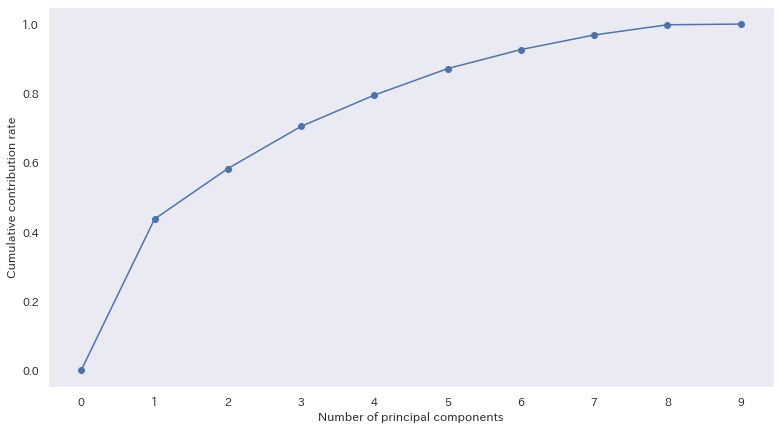

In [127]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca1.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [129]:
# PCA の固有ベクトル
pd.DataFrame(pca1.components_, columns=data_for_pca.columns[:-1], index=["PC{}".format(x + 1) for x in range(len(X.columns))])

,実験室測定_EC(㎳／㎝),実験室測定_pH,アンモニア態窒素(mgN/100g),硝酸態窒素(mgN/100g),可給隊窒素(mgN/100g),有効態リン酸(mgP2O5/100g),TC(%),TN(%),土壌_CD
PC1,-0.383938,0.401014,-0.090468,-0.311267,-0.229704,-0.225513,-0.451801,-0.473288,-0.234440
PC2,-0.038205,0.140698,0.684374,0.347678,-0.578845,0.047187,-0.045324,-0.018121,0.223217
PC3,0.146006,0.328014,-0.040179,0.369611,0.095071,0.641217,-0.090338,-0.070236,-0.547330
PC4,-0.439006,0.247423,-0.290546,-0.145846,-0.101224,0.550406,0.143808,0.096807,0.545089
PC5,-0.008122,-0.024204,0.586585,-0.336381,0.598992,0.253707,-0.238298,-0.176283,0.176335
PC6,-0.331884,0.006558,0.294334,-0.446501,-0.130412,0.050383,0.467756,0.349340,-0.493391
PC7,-0.627261,0.106311,0.068192,0.549239,0.431808,-0.293494,0.087793,0.087094,-0.032223
PC8,-0.361703,-0.799131,-0.037827,0.090823,-0.171537,0.282427,-0.209653,-0.213976,-0.148158
PC9,-0.050890,0.006201,-0.024918,-0.043844,-0.034758,-0.001351,-0.661617,0.744903,-0.031646


soil_data_wo_error_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','作付け開始年','土壌_CD','EVI20902mean','EVI20903mean']]

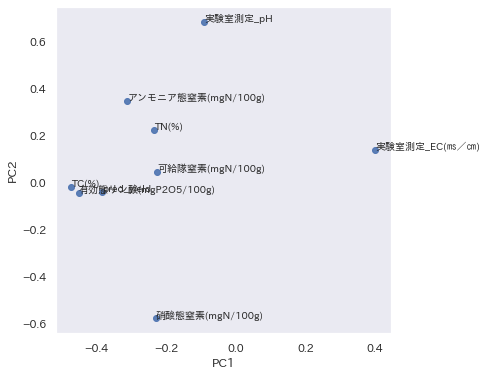

In [130]:
# 第一主成分と第二主成分における観測変数の寄与度をプロットする
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca1.components_[0], pca1.components_[1], data_only_yield_soil_sort.columns[:-1]):
    plt.text(x, y, name ,size = 'small' )
plt.scatter(pca1.components_[0], pca1.components_[1], alpha=0.9)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [131]:
x_transformed = pca1.transform(X)
x_transformed_pd = pd.DataFrame(x_transformed, columns=['第一主成分', '第二主成分', '第三主成分', '第四主成分', '第五主成分',
                                                        '第六主成分', '第七主成分', '第八主成分', '第九主成分'])

In [133]:
# 新しいPlotのために次元圧縮したデータに終了を結合
new_Y = Y.reset_index()
x_transformed_pd['pred_yield'] = new_Y['pred_yield']

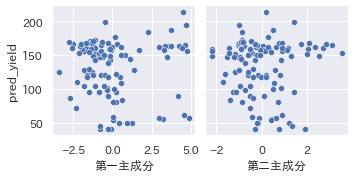

In [135]:
#　土壌採取データあら作成した主成分で終了との関係を表示
sns.pairplot(x_transformed_pd,  x_vars=['第一主成分', '第二主成分'],y_vars=['pred_yield'])